In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import matplotlib.pyplot as plt
import sys
import os
sys.path.append(os.path.abspath(os.path.join(os.path.abspath(''), "..")))
from example_package import model, training, datasets, metrics
import example_package

%load_ext autoreload
%autoreload 2

In [2]:
n_visible = 4
n_hidden = 2
dataset = datasets.BasicEncoderDataset(n_visible).data[:]

In [93]:
#model paramss
bias = True
epochs = 100
learning_rate = 2
noise_levels = [0.05,0.15] # [p_flip_to_zero,p_flip_to_one]
annealing_scheme = torch.Tensor([20,20,15,15,12,12,10,10,10,10])
steps_statistics = 10
train_params = {
    'double_clamped':False, #bad, do not use
    'discretize_gradients':True
}

In [96]:
model_B = model.BoltzmannMachine(2*n_visible, n_hidden, None, bias)
training.TrainBatch(model_B,dataset, epochs, learning_rate,noise_levels,steps_statistics,annealing_scheme,train_params,bar=True)

100%|██████████| 100/100 [00:03<00:00, 32.34it/s]


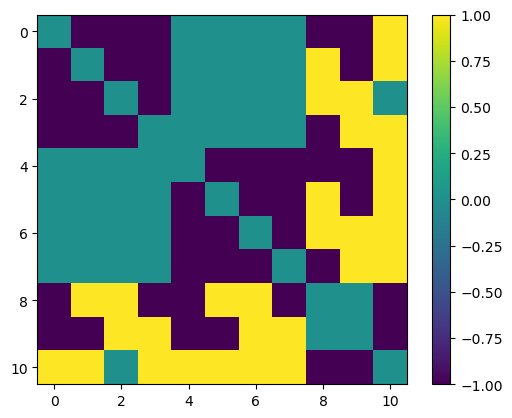

In [97]:
weight_mat_sign=np.sign(model_B.w.detach().numpy())

plt.imshow(weight_mat_sign,cmap='viridis')
plt.colorbar()

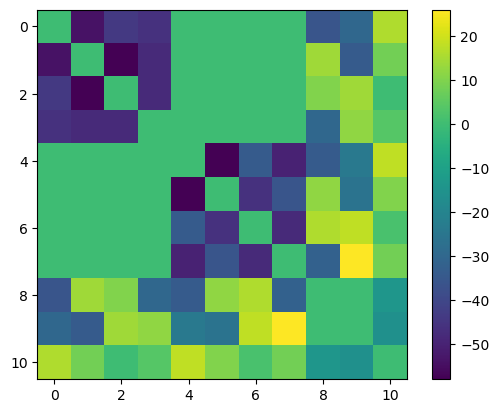

In [98]:
weight_mat=model_B.w.detach().numpy()
plt.imshow(weight_mat,cmap='viridis')
plt.colorbar()

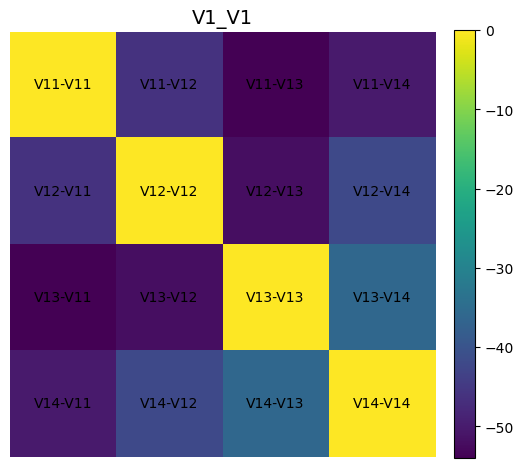

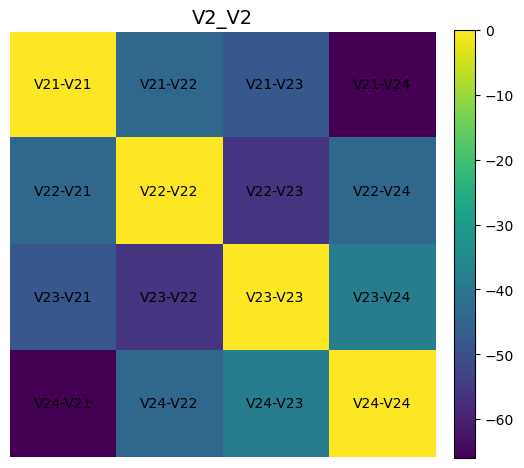

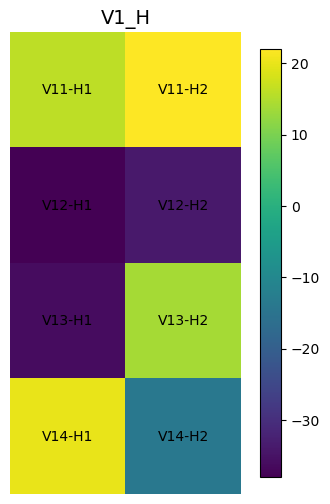

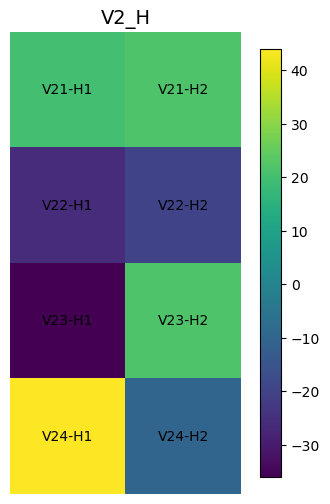

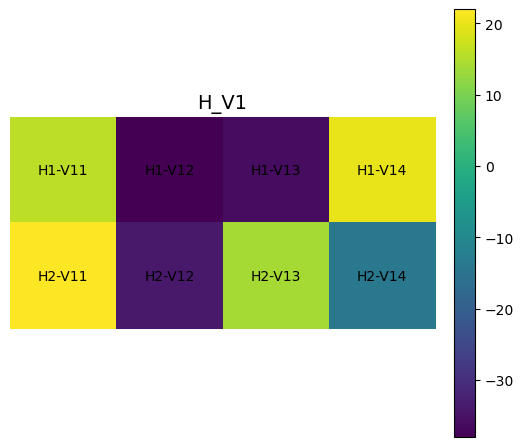

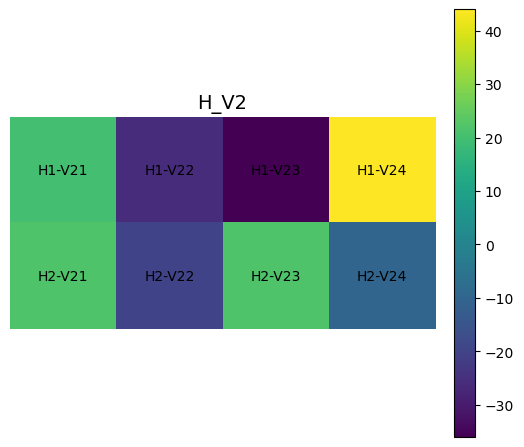

In [47]:
def PlotWeights_simple(weights, epoch):
    plt.figure(figsize=(8, 6))
    plt.imshow(weights, cmap='viridis', vmin=-1, vmax=1)
    plt.colorbar()
    plt.title(f'Weight Matrix at Epoch {epoch}')
    plt.xlabel('Units')
    plt.ylabel('Units')
    plt.show()

import numpy as np
import matplotlib.pyplot as plt

def extract_weight_matrices(weight_matrix, nv1, nv2, nh):
    
    # Extract the weight matrices
    V1_V1 = weight_matrix[:nv1, :nv1]  # V1 to V1 connections
    V2_V2 = weight_matrix[nv1:nv1+nv2, nv1:nv1+nv2]  # V2 to V2 connections
    V1_H = weight_matrix[:nv1, nv1+nv2:nv1+nv2+nh]  # V1 to H connections
    V2_H = weight_matrix[nv1:nv1+nv2, nv1+nv2:nv1+nv2+nh]  # V2 to H connections
    H_V1 = weight_matrix[nv1+nv2:nv1+nv2+nh, :nv1]  # H to V1 connections
    H_V2 = weight_matrix[nv1+nv2:nv1+nv2+nh, nv1:nv1+nv2]  # H to V2 connections

    # Return the labeled weight matrices as a dictionary
    return {
        "V1_V1": V1_V1,
        "V2_V2": V2_V2,
        "V1_H": V1_H,
        "V2_H": V2_H,
        "H_V1": H_V1,
        "H_V2": H_V2
    }

def plot_weight_matrices(weight_matrices):
    for label, matrix in weight_matrices.items():
        plt.figure(figsize=(6, 6))
        plt.title(label, fontsize=14)
        
        # Plot the heatmap with fixed color range
        im = plt.imshow(matrix, cmap='viridis', interpolation='nearest')
        plt.colorbar(im, fraction=0.046, pad=0.04)  # Add a colorbar
        
        # Add connection labels to each cell
        rows, cols = matrix.shape
        for i in range(rows):
            for j in range(cols):
                # Determine the connection type based on the position
                if label == "V1_V1":
                    connection_label = f"V1{i+1}-V1{j+1}"
                elif label == "V2_V2":
                    connection_label = f"V2{i+1}-V2{j+1}"
                elif label == "V1_H":
                    connection_label = f"V1{i+1}-H{j+1}"
                elif label == "V2_H":
                    connection_label = f"V2{i+1}-H{j+1}"
                elif label == "H_V1":
                    connection_label = f"H{i+1}-V1{j+1}"
                elif label == "H_V2":
                    connection_label = f"H{i+1}-V2{j+1}"
                
                # Add the connection label as text (always in black)
                plt.text(j, i, connection_label, ha="center", va="center", color="black")
        
        # Remove axis labels and ticks
        plt.axis('off')
        plt.show()

# Example usage:
# Create a symmetric weight matrix for a 4-2-4 Boltzmann Machine
nv1 = 4
nv2 = 4
nh = 2
total_units = nv1 + nv2 + nh


# Extract the weight matrices
weight_matrices = extract_weight_matrices(weight_mat, nv1, nv2, nh)

# Plot the weight matrices with a fixed color range (-30 to 30)
plot_weight_matrices(weight_matrices)

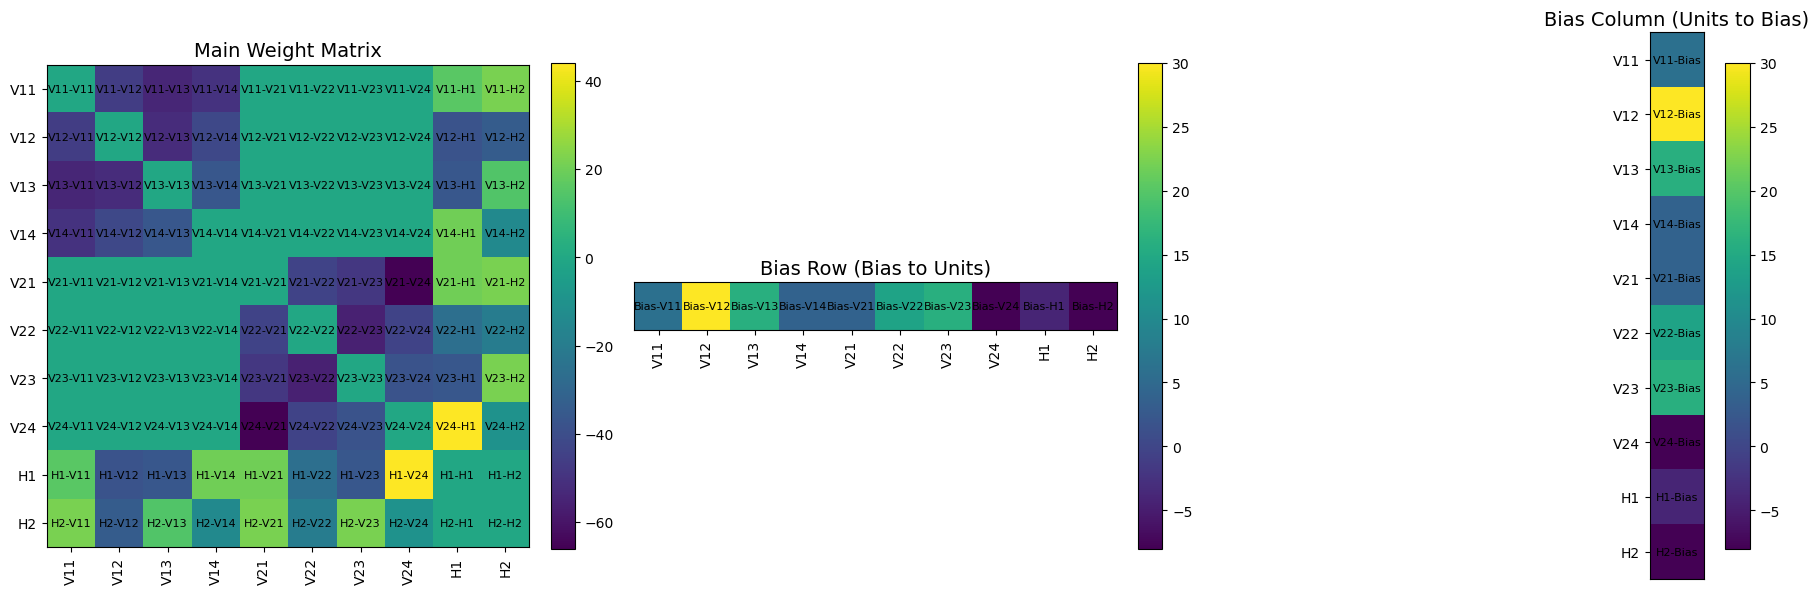

In [49]:
import numpy as np
import matplotlib.pyplot as plt

def label_weight_matrix(weight_matrix, nv1, nv2, nh):
    
    # Define the labels for rows and columns
    labels = []
    for i in range(nv1):
        labels.append(f"V1{i+1}")  # Label V1 units
    for i in range(nv2):
        labels.append(f"V2{i+1}")  # Label V2 units
    for i in range(nh):
        labels.append(f"H{i+1}")   # Label H units
    labels.append("Bias")  # Add bias label

    # Extract the bias row and column (11th row and column)
    bias_row = weight_matrix[-1, :-1]  # Last row, excluding the bias-bias term
    bias_col = weight_matrix[:-1, -1]  # Last column, excluding the bias-bias term
    bias_bias = weight_matrix[-1, -1]  # Bias-bias term (usually 0)

    # Remove the bias row and column from the main weight matrix
    main_matrix = weight_matrix[:-1, :-1]

    # Create a figure with subplots for the main matrix and bias terms
    fig, axes = plt.subplots(1, 3, figsize=(18, 6))

    # Plot the main weight matrix
    im_main = axes[0].imshow(main_matrix, cmap='viridis', interpolation='nearest')
    axes[0].set_title("Main Weight Matrix", fontsize=14)
    plt.colorbar(im_main, ax=axes[0], fraction=0.046, pad=0.04)

    # Add connection labels to each cell in the main matrix
    for i in range(len(labels) - 1):  # Exclude bias label
        for j in range(len(labels) - 1):  # Exclude bias label
            axes[0].text(j, i, f"{labels[i]}-{labels[j]}", ha="center", va="center", color="black", fontsize=8)

    # Add row and column labels for the main matrix
    axes[0].set_xticks(range(len(labels) - 1))
    axes[0].set_xticklabels(labels[:-1], rotation=90)
    axes[0].set_yticks(range(len(labels) - 1))
    axes[0].set_yticklabels(labels[:-1])

    # Plot the bias row (connections from bias to all units)
    im_bias_row = axes[1].imshow(bias_row.reshape(1, -1), cmap='viridis', interpolation='nearest')
    axes[1].set_title("Bias Row (Bias to Units)", fontsize=14)
    plt.colorbar(im_bias_row, ax=axes[1], fraction=0.046, pad=0.04)

    # Add labels for the bias row
    for j in range(len(labels) - 1):  # Exclude bias label
        axes[1].text(j, 0, f"Bias-{labels[j]}", ha="center", va="center", color="black", fontsize=8)

    # Add column labels for the bias row
    axes[1].set_xticks(range(len(labels) - 1))
    axes[1].set_xticklabels(labels[:-1], rotation=90)
    axes[1].set_yticks([])  # Hide y-axis for bias row

    # Plot the bias column (connections from all units to bias)
    im_bias_col = axes[2].imshow(bias_col.reshape(-1, 1), cmap='viridis', interpolation='nearest')
    axes[2].set_title("Bias Column (Units to Bias)", fontsize=14)
    plt.colorbar(im_bias_col, ax=axes[2], fraction=0.046, pad=0.04)

    # Add labels for the bias column
    for i in range(len(labels) - 1):  # Exclude bias label
        axes[2].text(0, i, f"{labels[i]}-Bias", ha="center", va="center", color="black", fontsize=8)

    # Add row labels for the bias column
    axes[2].set_yticks(range(len(labels) - 1))
    axes[2].set_yticklabels(labels[:-1])
    axes[2].set_xticks([])  # Hide x-axis for bias column

    # Show the plot
    plt.tight_layout()
    plt.show()

# Example usage:
# Create a symmetric weight matrix for a 4-2-4 Boltzmann Machine with bias
nv1 = 4
nv2 = 4
nh = 2
total_units = nv1 + nv2 + nh + 1  # +1 for bias

# Label and plot the entire weight matrix with bias separation
label_weight_matrix(weight_mat, nv1, nv2, nh)

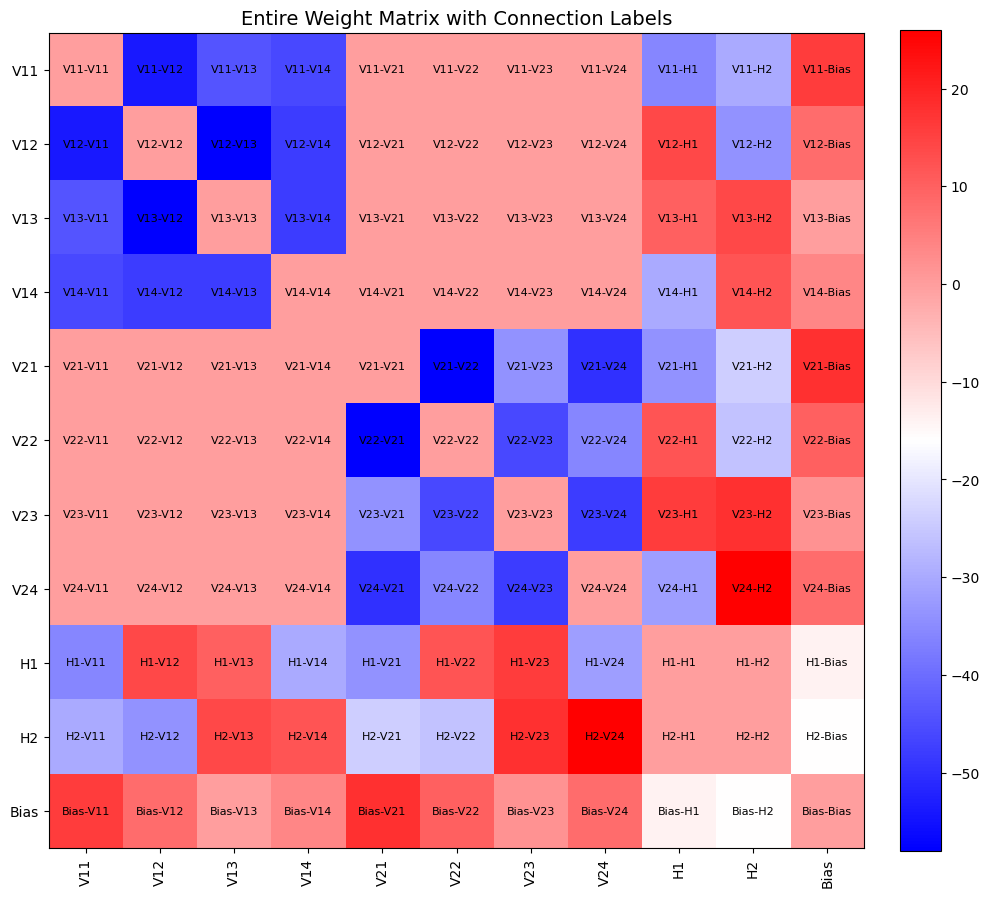

In [100]:
def label_entire_weight_matrix(weight_matrix, nv1, nv2, nh):
    # Define the labels for rows and columns
    labels = []
    for i in range(nv1):
        labels.append(f"V1{i+1}")  # Label V1 units
    for i in range(nv2):
        labels.append(f"V2{i+1}")  # Label V2 units
    for i in range(nh):
        labels.append(f"H{i+1}")   # Label H units
    labels.append("Bias")  # Add bias label

    # Create a figure and plot the heatmap
    plt.figure(figsize=(10, 10))
    im = plt.imshow(weight_matrix, cmap='bwr', interpolation='nearest')
    plt.colorbar(im, fraction=0.046, pad=0.04)  # Add a colorbar

    # Add connection labels to each cell
    for i in range(len(labels)):
        for j in range(len(labels)):
            # Label each cell with the connection type (e.g., V1-V1, V1-H1, Bias-V1, etc.)
            plt.text(j, i, f"{labels[i]}-{labels[j]}", ha="center", va="center", color="black", fontsize=8)

    # Add row and column labels
    plt.xticks(range(len(labels)), labels, rotation=90)
    plt.yticks(range(len(labels)), labels)

    # Show the plot
    plt.title("Entire Weight Matrix with Connection Labels", fontsize=14)
    plt.tight_layout()
    plt.savefig("Weight_Mat_Labels_5.pdf")
    plt.show()

# Example usage:
# Create a symmetric weight matrix for a 4-2-4 Boltzmann Machine with bias
nv1 = 4
nv2 = 4
nh = 2
total_units = nv1 + nv2 + nh + 1  # +1 for bias

# Label and plot the entire weight matrix with bias
label_entire_weight_matrix(weight_mat, nv1, nv2, nh)